In [17]:
import pandas as pd
import numpy as np
import os.path
from sklearn.feature_extraction.text import CountVectorizer
import pickle as pkl
from time import time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import ParameterGrid
from random import sample
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import ensemble, preprocessing, metrics

In [2]:
# Load data with label
data201511 = pd.read_csv("small_2015-11_key_word.csv",index_col=False, header=None)
data201511.columns = np.array([str(i) for i in data201511.columns.values])
data201506 = pd.read_csv("small_2015-06_key_word.csv",index_col=False, header=None)
data201506.columns = np.array([str(i) for i in data201506.columns.values])

In [3]:
data2015 =  pd.concat([data201506, data201511])
data2015 = data2015[data2015['1'].notnull()]
data2015.groupby(data2015['4']).size()

4
0    8610183
1     491745
2     413578
3      19987
dtype: int64

In [43]:
# The column 4 is label, 
# when 0 means no mention to foods or activity, 1 means mention food , 
# 2 means mention activity and 3 means both are mentioned
data2015.head()

,0,1,2,3,4
0,611053325644005376,she say unenthused,NaN,NaN,0
1,611162865551192064,for ailment sun remedy none if try find,NaN,NaN,0
2,611058983927836673,yeah rest conditioning summer,NaN,NaN,0
3,611165766952591360,remind blessed i walk office today,NaN,walk,2
4,611159320655347712,unarmed white teen shot black officer,NaN,NaN,0


In [4]:
data2015_0 = data2015[data2015['4']==0]
data2015_0_balanced = data2015_0.sample(512000)
data2015_food = data2015[(data2015['4']==1) | (data2015['4']==3) ]

In [5]:
data_model = pd.concat([data2015_0_balanced, data2015_food])
data_model =data_model.sample(frac=1).reset_index(drop=True)

In [6]:
data_model = data_model.drop(['2','3'],axis = 1)
data_model.columns = ['TweetsID','Tokenized_text','label']
data_model = data_model.replace(3,1)
data_model.groupby('label').size()

label
0    512000
1    511732
dtype: int64

In [8]:
data_model.head()

,TweetsID,Tokenized_text,label
0,610517805981663232,pizza pizza pizza two boots east village new y...,1
1,608516489952387072,why i run burrito,1
2,611051427499110401,when jacob put flashlight ballsack idk i hango...,0
3,671404098084843520,nice pumpkin beer good nose drinking pumpkin ale,1
4,670807301519970304,there time ticket dec 4th dj sylk schomburg ce...,0
5,611754622621982720,here inspiration come thank you miami fully re...,0
6,612682507662815236,pull pork black eyed pea candy sweet potato si...,1
7,661986223762878464,day try place oyster wh stiles fish camp dub s,1
8,615168157695799297,i be apple store king street charleston sc,1
9,611881898164404224,american water works acquire Pennsylvania util...,1


In [7]:
length = [len(data_model.Tokenized_text.iloc[i].split()) for i in range(len(data_model))]
length.sort()

In [8]:
import collections
collections.Counter(length)
dict_len = dict(collections.Counter(length))

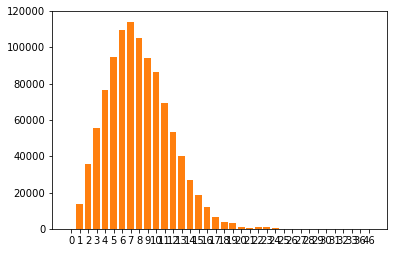

In [12]:
from matplotlib import pyplot as plt
plt.bar(range(len(dict_len)), list(dict_len.values()), align='center')
plt.xticks(range(len(dict_len)), list(dict_len.keys()))
plt.show()

In [9]:
# Only keep tokenized text of lengths more than 4
idx = [i for i in range(len(data_model)) if len(data_model.Tokenized_text.iloc[i].split()) >=5]
data_model = data_model.iloc[idx]

In [35]:
len(data_model)

842063

In [38]:
data_model.groupby('label').size()

label
0    382502
1    459561
dtype: int64

## tpoics 75, maxfeature 16000, maxDF 0.4

In [37]:
def add_lda(num_topics,max_features,max_df,min_df,data_model):
    tf_path = 'saved_model/tfVectorizer_topics={}_maxFeatures={}_maxDf={}_minDf={}.pickle'.format(num_topics,max_features,max_df,min_df)
    lda_path = 'saved_model/LDA_topics={}_maxFeatures={}_maxDf={}_minDf={}.pickle'.format(num_topics,max_features,max_df,min_df)
    with open(tf_path,'rb') as input_file:
        tf_vectorizer = pkl.load(input_file)
    with open(lda_path, "rb") as input_file:
        lda = pkl.load(input_file)
    prob_arr = lda.transform(tf_vectorizer.transform(data_model['Tokenized_text']))
    new_cols = ['topics_{}'.format(i+1) for i in range(num_topics)]
    new_vals = [list(topic_prob[i]) for i in range(len(data_model))]
    data_ft = data_model.reindex(columns=data_model.columns.tolist() + new_cols)   # add empty cols
    data_ft[new_cols] = new_vals 
    X = data_ft[['topics_{}'.format(i+1) for i in range(num_topics)]]
    y = data_ft.label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return data_ft, X_train, X_test, y_train, y_test

In [39]:
with open("tfVectorizer_topics=75_maxFeatures=16000_maxDf=0.4_minDf=1.pickle", "rb") as input_file:
    tf_vectorizer = pkl.load(input_file)
with open("LDA_topics=75_maxFeatures=16000_maxDf=0.4_minDf=1.pickle", "rb") as input_file:
    lda = pkl.load(input_file)

In [40]:
 topic_prob = lda.transform(tf_vectorizer.transform(data_model['Tokenized_text']))

In [41]:
new_cols = ['topics_{}'.format(i+1) for i in range(75)]
new_vals = [list(topic_prob[i]) for i in range(len(data_model))]
data_ft = data_model.reindex(columns=data_model.columns.tolist() + new_cols)   # add empty cols
data_ft[new_cols] = new_vals 

In [42]:
data_ft.head()


,TweetsID,Tokenized_text,label,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,...,topics_66,topics_67,topics_68,topics_69,topics_70,topics_71,topics_72,topics_73,topics_74,topics_75
0,666677687038119936,do not sleep tory lanez the observatory orange...,1,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,...,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905
2,663148942906023940,fish triple cooked chips new improved farmersg...,1,0.002222,0.002222,0.002222,0.002222,0.168889,0.002222,0.002222,...,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222
3,610628075341135872,sgi blue parrot oceanfront cafe,0,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,...,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333
4,665696902982279168,fall fire northern california santa clara cali...,0,0.001667,0.001667,0.001667,0.001667,0.126667,0.001667,0.001667,...,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667
5,606862658453794816,my baby kindergarten year it yesterday fat lit...,1,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.144762,...,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905,0.001905


In [28]:
X = data_ft[['topics_{}'.format(i+1) for i in range(75)]]
y = data_ft.label
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:

clf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=2,
                            random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [31]:
y_test_predicted = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_test_predicted)
print(accuracy)

0.6237048208867486


In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predicted)
metrics.auc(fpr, tpr)    

0.6070936475442197

## tpoics 25, maxfeature 16000, maxDF 0.4

In [10]:
with open("saved_model/tfVectorizer_topics=25_maxFeatures=16000_maxDf=0.4_minDf=1.pickle", "rb") as input_file:
    tf_vectorizer1 = pkl.load(input_file)
with open("saved_model/LDA_topics=25_maxFeatures=16000_maxDf=0.4_minDf=1.pickle", "rb") as input_file:
    lda1 = pkl.load(input_file)

In [11]:
topic_prob1 = lda1.transform(tf_vectorizer1.transform(data_model['Tokenized_text']))

In [13]:
new_cols = ['topics_{}'.format(i+1) for i in range(25)]
new_vals = [list(topic_prob1[i]) for i in range(len(data_model))]
data_ft1 = data_model.reindex(columns=data_model.columns.tolist() + new_cols)   # add empty cols
data_ft1[new_cols] = new_vals 

In [14]:
X1 = data_ft1[['topics_{}'.format(i+1) for i in range(25)]]
y1 = data_ft1.label
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [18]:
clf1 = ensemble.RandomForestClassifier(n_estimators=100, max_depth=2,
                            random_state=0)
clf1.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
y_test_predicted1 = clf1.predict(X_test1)
accuracy1 = metrics.accuracy_score(y_test1, y_test_predicted1)
print(accuracy1)

0.620928493423864


In [20]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test1, y_test_predicted1)
metrics.auc(fpr1, tpr1)   

0.6053337092917872

## tpoics 25, maxfeature 16000, maxDF 0.4

In [21]:
with open("saved_model/tfVectorizer_topics=25_maxFeatures=12000_maxDf=0.4_minDf=1.pickle", "rb") as input_file:
    tf_vectorizer1 = pkl.load(input_file)
with open("saved_model/LDA_topics=25_maxFeatures=12000_maxDf=0.4_minDf=1.pickle", "rb") as input_file:
    lda1 = pkl.load(input_file)

In [22]:
topic_prob2 = lda1.transform(tf_vectorizer1.transform(data_model['Tokenized_text']))

In [23]:
new_cols = ['topics_{}'.format(i+1) for i in range(25)]
new_vals = [list(topic_prob2[i]) for i in range(len(data_model))]
data_ft2 = data_model.reindex(columns=data_model.columns.tolist() + new_cols)   # add empty cols
data_ft2[new_cols] = new_vals 

In [24]:
X1 = data_ft2[['topics_{}'.format(i+1) for i in range(25)]]
y1 = data_ft2.label
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [25]:
clf2 = ensemble.RandomForestClassifier(n_estimators=100, max_depth=2,
                            random_state=0)
clf2.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
y_test_predicted1 = clf2.predict(X_test1)
accuracy1 = metrics.accuracy_score(y_test1, y_test_predicted1)
print(accuracy1)

0.6122157067565642


## topics 100， max Feature 12000, maxDF 0.4

In [28]:
with open("tfVectorizer_topics=100_maxFeatures=12000_maxDf=0.4_minDf=1.pickle", "rb") as input_file:
    tf_vectorizer1 = pkl.load(input_file)
with open("LDA_topics=100_maxFeatures=12000_maxDf=0.4_minDf=1.pickle", "rb") as input_file:
    lda1 = pkl.load(input_file)


In [29]:
topic_prob2 = lda1.transform(tf_vectorizer1.transform(data_model['Tokenized_text']))

In [31]:
new_cols = ['topics_{}'.format(i+1) for i in range(100)]
new_vals = [list(topic_prob2[i]) for i in range(len(data_model))]
data_ft3 = data_model.reindex(columns=data_model.columns.tolist() + new_cols)   # add empty cols
data_ft3[new_cols] = new_vals 

In [32]:
X1 = data_ft3[['topics_{}'.format(i+1) for i in range(25)]]
y1 = data_ft3.label
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [33]:
clf3 = ensemble.RandomForestClassifier(n_estimators=100, max_depth=2,
                            random_state=0)
clf3.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [34]:
y_test_predicted1 = clf2.predict(X_test1)
accuracy1 = metrics.accuracy_score(y_test1, y_test_predicted1)
print(accuracy1)

0.5452910593039267
